## 数据分析目的

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = ['Arial Unicode MS'] 

In [4]:
os.chdir('/data/RFM')

In [5]:
df = pd.read_csv('PYTHON-RFM实战数据.csv', usecols=['买家昵称', '付款日期', '订单状态', '实付金额', '购买数量' ])
df.head()

,买家昵称,付款日期,订单状态,实付金额,购买数量
0,叫我李2,2019/1/1 0:17,交易成功,186,1
1,0cyb1992,2019/1/1 0:59,交易成功,145,1
2,萝污萌莉,2019/1/1 7:48,交易成功,194,1
3,atblovemyy,2019/1/1 9:15,付款以后用户退款成功，交易自动关闭,84,1
4,小星期鱼,2019/1/1 9:59,付款以后用户退款成功，交易自动关闭,74,1


## 数据源解释
- 数据文本是 2019/09/01 拉取的一份数据
- 没一行代表一笔订单，一个买家昵称可以产生多行订单
- 订单类型包括“交易成功”以及其他订单类型

## 数据信息概览
### 数据类型



In [6]:
# 数据类型
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28833 entries, 0 to 28832
Data columns (total 5 columns):
买家昵称    28833 non-null object
付款日期    28833 non-null object
订单状态    28833 non-null object
实付金额    28833 non-null int64
购买数量    28833 non-null int64
dtypes: int64(2), object(3)
memory usage: 1.1+ MB


### 数据大小/数据量

In [7]:
# 数据行、列数量
df.shape

(28833, 5)

### 数据检查：缺省值

In [8]:
#  查看每一列缺失值情况，城市一列存在缺失情况
df.isnull().sum()

买家昵称    0
付款日期    0
订单状态    0
实付金额    0
购买数量    0
dtype: int64

### 数据检查：数据唯一性

In [9]:
# 检查订单状态唯一性，发现订单状态有两种类型：交易成功；交易自动关闭
df['订单状态'].unique()

array(['交易成功', '付款以后用户退款成功，交易自动关闭'], dtype=object)

### 数据检查：重复值

In [10]:
# 查看‘买家昵称’这一列，有2884条重复值
df.duplicated('买家昵称').sum()

2884

### 数据检查：异常值

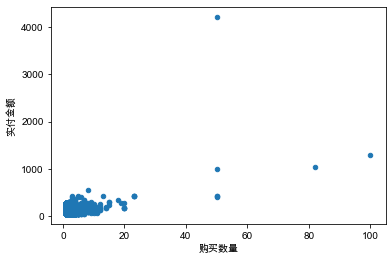

In [11]:
# 观测购买数量和实付金额对应的异常值，可以基于业务考虑来看是否需要删除或者做其他处理。本例中异常值较少，样本量，可以考虑直接删除
df.plot(kind='scatter',x='购买数量',y='实付金额'  )

## 数据整理

### 选取需要字段/类型

In [12]:
# 选取需要的字段
df = df[['买家昵称', '订单状态', '付款日期', '实付金额', '购买数量']]

# 只选取交易成功类型
df = df[df['订单状态'] == '交易成功']
df.head()

,买家昵称,订单状态,付款日期,实付金额,购买数量
0,叫我李2,交易成功,2019/1/1 0:17,186,1
1,0cyb1992,交易成功,2019/1/1 0:59,145,1
2,萝污萌莉,交易成功,2019/1/1 7:48,194,1
5,重碎叠,交易成功,2019/1/1 10:00,197,1
6,iho_jann,交易成功,2019/1/1 10:00,168,1


### 处理异常值

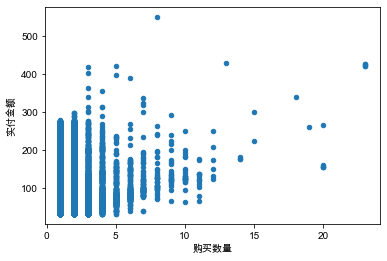

In [13]:
# 根据业务经验，对购买数量和实付金额做数据处理。去掉异常值后数据显示合理
df = df[df['购买数量'] < 40]
df = df[df['实付金额'] < 3000]
df.plot(kind='scatter',x='购买数量',y='实付金额')

### 处理数据类型

In [14]:
# 把付款日期由字符串转换成datetime类型
df['付款日期'] = pd.to_datetime(df['付款日期'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27786 entries, 0 to 28832
Data columns (total 5 columns):
买家昵称    27786 non-null object
订单状态    27786 non-null object
付款日期    27786 non-null datetime64[ns]
实付金额    27786 non-null int64
购买数量    27786 non-null int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 1.3+ MB


## 数据探索

In [15]:
# R值：最近一次购买时间距离今日时间
r = df.groupby('买家昵称')['付款日期'].max().reset_index()
r['r'] = (pd.to_datetime('2019-7-1') - r['付款日期']).dt.days
r = r[['买家昵称', 'r']]

# F值：计算用户累计购买次数
f= df.groupby('买家昵称')['付款日期'].count().reset_index()
f.columns = ['买家昵称', 'f']
f = f[['f']]

# M值：客单价
m = df.groupby('买家昵称')['实付金额'].sum().reset_index()
m['m'] = m['实付金额'] / f['f']
m = m[['m']]

# RMF三张表合并
rfm = pd.concat([r, f, m], axis=1)
rfm.head()

,买家昵称,r,f,m
0,.blue_ram,146,1,49.0
1,.christiny,152,1,183.0
2,.willn1,170,1,34.0
3,.托托m,170,1,37.0
4,0000妮,2,1,164.0


In [16]:
rfm['F-SCORE'] = pd.cut(rfm['f'], bins=[1,2,3,4,5,1000000], labels=[1, 2, 3, 4, 5], right = False).astype(float)
rfm['R-SCORE'] = pd.cut(rfm['r'],bins = [0,30,60,90,120,1000000],labels = [5,4,3,2,1],right = False).astype(float)
rfm['M-SCORE'] = pd.cut(rfm['m'],bins = [0,50,100,150,200,1000000],labels = [1,2,3,4,5],right = False).astype(float)
rfm.head()

,买家昵称,r,f,m,F-SCORE,R-SCORE,M-SCORE
0,.blue_ram,146,1,49.0,1.0,1.0,1.0
1,.christiny,152,1,183.0,1.0,1.0,4.0
2,.willn1,170,1,34.0,1.0,1.0,1.0
3,.托托m,170,1,37.0,1.0,1.0,1.0
4,0000妮,2,1,164.0,1.0,5.0,4.0


In [17]:
# Python中判断后返回的结果是True和False，对应着数值1和0，只要把这个布尔结果乘上1，True就变成了1，False变成了0，处理之后更加易读
rfm['R是否大于均值'] = (rfm['R-SCORE'] > rfm['R-SCORE'].mean()) * 1
rfm['F是否大于均值'] = (rfm['F-SCORE'] > rfm['F-SCORE'].mean()) * 1
rfm['M是否大于均值'] = (rfm['M-SCORE'] > rfm['M-SCORE'].mean()) * 1
rfm.head()

,买家昵称,r,f,m,F-SCORE,R-SCORE,M-SCORE,R是否大于均值,F是否大于均值,M是否大于均值
0,.blue_ram,146,1,49.0,1.0,1.0,1.0,0,0,0
1,.christiny,152,1,183.0,1.0,1.0,4.0,0,0,1
2,.willn1,170,1,34.0,1.0,1.0,1.0,0,0,0
3,.托托m,170,1,37.0,1.0,1.0,1.0,0,0,0
4,0000妮,2,1,164.0,1.0,5.0,4.0,1,0,1


In [18]:
rfm['人群数值'] = (rfm['R是否大于均值'] * 100) + (rfm['F是否大于均值'] * 10) + (rfm['M是否大于均值'] * 1)
rfm.head()

,买家昵称,r,f,m,F-SCORE,R-SCORE,M-SCORE,R是否大于均值,F是否大于均值,M是否大于均值,人群数值
0,.blue_ram,146,1,49.0,1.0,1.0,1.0,0,0,0,0
1,.christiny,152,1,183.0,1.0,1.0,4.0,0,0,1,1
2,.willn1,170,1,34.0,1.0,1.0,1.0,0,0,0,0
3,.托托m,170,1,37.0,1.0,1.0,1.0,0,0,0,0
4,0000妮,2,1,164.0,1.0,5.0,4.0,1,0,1,101


In [19]:
#判断R/F/M是否大于均值
def transform_label(x):
    if x == 111:
        label = '重要价值客户'
    elif x == 110:
        label = '消费潜力客户'
    elif x == 101:
        label = '频次深耕客户'
    elif x == 100:
        label = '新客户'
    elif x == 11:
        label = '重要价值流失预警客户'
    elif x == 10:
        label = '一般客户'
    elif x == 1:
        label = '高消费唤回客户'
    elif x == 0:
        label = '流失客户'
    return label

In [20]:
rfm['人群类型'] = rfm['人群数值'].apply(transform_label)
rfm.head()

,买家昵称,r,f,m,F-SCORE,R-SCORE,M-SCORE,R是否大于均值,F是否大于均值,M是否大于均值,人群数值,人群类型
0,.blue_ram,146,1,49.0,1.0,1.0,1.0,0,0,0,0,流失客户
1,.christiny,152,1,183.0,1.0,1.0,4.0,0,0,1,1,高消费唤回客户
2,.willn1,170,1,34.0,1.0,1.0,1.0,0,0,0,0,流失客户
3,.托托m,170,1,37.0,1.0,1.0,1.0,0,0,0,0,流失客户
4,0000妮,2,1,164.0,1.0,5.0,4.0,1,0,1,101,频次深耕客户


In [21]:
# 人群占比
count = rfm['人群类型'].value_counts().reset_index()
count.columns = ['人群类型', '人数']
count['人数占比'] = count['人数'] / count['人数'].sum()


# 消费占比
rfm['消费总金额'] = rfm['m'] * rfm['f']

rfm_group = rfm.groupby('人群类型')['消费总金额'].sum().reset_index()


rfm_group['消费占比'] = rfm_group['消费总金额'] / rfm_group['消费总金额'].sum()
rfm_group

group = pd.merge(count, rfm_group)
group

,人群类型,人数,人数占比,消费总金额,消费占比
0,高消费唤回客户,7130,0.280499,1282069.0,0.366041
1,流失客户,6670,0.262402,443773.0,0.126701
2,频次深耕客户,5349,0.210433,956139.0,0.272985
3,新客户,4218,0.165939,270412.0,0.077205
4,重要价值客户,808,0.031787,282654.0,0.080700
5,重要价值流失预警客户,499,0.019631,160455.0,0.045811
6,消费潜力客户,482,0.018962,69369.0,0.019805
7,一般客户,263,0.010347,37661.0,0.010753


## 数据可视化

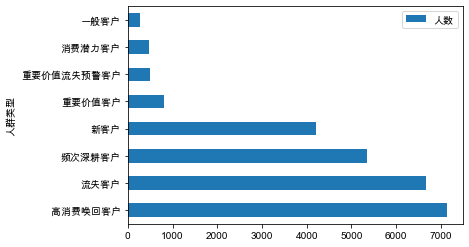

In [22]:
group.plot(x='人群类型', y='人数', kind='barh')

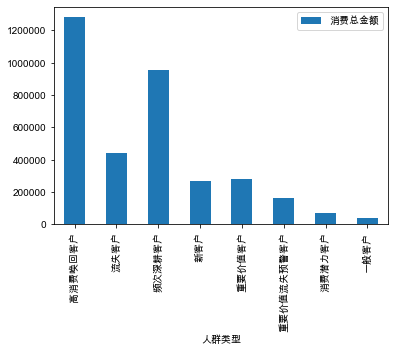

In [23]:
group.plot(x='人群类型', y='消费总金额', kind='bar')

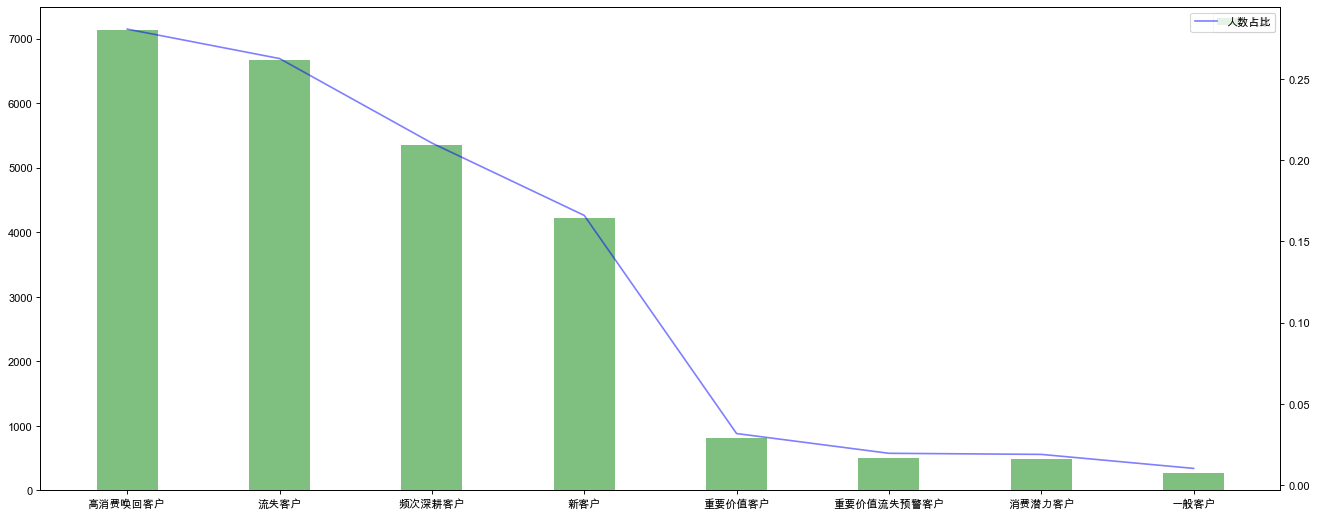

In [91]:
fig1,ax1=plt.subplots(figsize=(20,8),dpi=80)
ax1.bar(count['人群类型'],count['人数'],color = 'green',alpha=0.5,width=0.4,label= '人数'),#rotation=45
ax1.legend()


ax2 = ax1.twinx()
ax2.plot(count['人群类型'],count['人数占比'],color = 'b',alpha=0.5,label = '人数占比')
ax2.legend()
plt.show()

In [50]:

ax2 = ax1.twinx()
ax2.plot(count['人群类型'],count['人数占比'],color = 'b',alpha=0.5,label = '人数占比')
ax2.legend(labels=['人数','人数占比'],loc='best')
plt.show()

## 结论